# Model Training & Evaluation

This notebook trains a Random Forest regression model to predict average weekly 311 complaint volumes using aggzregated spatial and temporal features.

The model performance is evaluated using R², MAE, and RMSE, analyze feature importance, and the trained model and metadata is saved.

# Imports & Setup

In [11]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

pd.set_option("display.max_columns", 200)
np.random.seed(42)


## Step 1: Load Aggregated Training Data

We load pre-aggregated complaint statistics produced in the feature engineering pipeline.

In [12]:
agg_data = pd.read_csv("../data/processed/aggregated_data.csv")

print(f"Loaded {len(agg_data):,} aggregated records")
agg_data.head()


Loaded 5,880 aggregated records


,Borough,Neighborhood,Season,Day_of_Week,Time_Bucket,Avg_Complaints_Per_Week,Std_Complaints,Num_Weeks
0,BRONX,Bronx Park and Fordham,Fall,0,afternoon,12.243590,7.010541,78
1,BRONX,Bronx Park and Fordham,Fall,0,evening,19.102564,20.579014,78
2,BRONX,Bronx Park and Fordham,Fall,0,morning,7.794872,7.741537,78
3,BRONX,Bronx Park and Fordham,Fall,0,night,25.269231,23.303571,78
4,BRONX,Bronx Park and Fordham,Fall,0,overnight,8.636364,8.992554,77


## Step 2: Feature Selection & Target Definition

Here, spatial and temporal categorical features are used to predict the average number of complaints per week.

In [13]:
feature_cols = [
    'Borough',
    'Neighborhood',
    'Season',
    'Day_of_Week',
    'Time_Bucket'
]

target_col = 'Avg_Complaints_Per_Week'

X = pd.get_dummies(agg_data[feature_cols], drop_first=False)
y = agg_data[target_col]

print(f"Feature matrix shape: {X.shape}")
print(f"Target range: {y.min():.1f} → {y.max():.1f}")


Feature matrix shape: (5880, 57)
Target range: 1.0 → 180.3


## Step 3: Train–Test Split

20% of the data is saved for testing/out-of-sample evaluation and 80% is saved for training the model.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

print(f"Training samples: {len(X_train):,}")
print(f"Test samples: {len(X_test):,}")


Training samples: 4,704
Test samples: 1,176


## Step 4: Model Training

The Random Forest regressor model is trained with constrained depth and minimum leaf sizes to reduce overfitting.


In [15]:
model = RandomForestRegressor(
    n_estimators=200,
    max_depth=20,
    min_samples_split=8,
    min_samples_leaf=3,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

model.fit(X_train, y_train)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.1s finished


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",200
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",20
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",8
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",3
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsampl

## Step 5: Model Evaluation

The model performace is evaluated using R², MAE, and RMSE on both training and test sets to assess generalization.


In [16]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Errors
errors = np.abs(y_test - y_pred_test) 

r2_train = r2_score(y_train, y_pred_train)
r2_test  = r2_score(y_test, y_pred_test)

mae_train = mean_absolute_error(y_train, y_pred_train)
mae_test  = mean_absolute_error(y_test, y_pred_test)

rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_test  = np.sqrt(mean_squared_error(y_test, y_pred_test))

metrics = pd.DataFrame({
    "Metric": ["R²", "MAE", "RMSE"],
    "Train":  [r2_train, mae_train, rmse_train],
    "Test":   [r2_test,  mae_test,  rmse_test]
})

metrics



[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 200 out of 200 | elapsed:    0.0s finished


,Metric,Train,Test
0,R²,0.814320,0.741073
1,MAE,2.555231,2.875239
2,RMSE,5.336693,6.531382


Overfitting Check: A gap greater than ~0.15 between training and test R² may indicate overfitting.
Because the gap is .07 from train to test, this is a good model.

the R^2 test shows that the model explains 74.1% of variance explained on unseen data.

- MAE (Mean Absolute Error):
    - On average, predictions are off by 2.88 complaints per week. This means the model is well-calibrated for practical use.
    - Given the weekly aggregation, this is very tight.
- RMSE (Root Mean Squared Error):
    - RMSE > MAE means that model occassionally misse higher-volume weeks. The model captures typical behavior very well but extreme surges remain harder (normal for civic data)


## Feature Importance Analysis

Here, the random Forest feature importances highlights which spatial and temporal factors most influence complaint volume.


In [17]:
feature_importance = pd.DataFrame({
    "feature": X.columns,
    "importance": model.feature_importances_
}).sort_values("importance", ascending=False)

feature_importance.head(20)


,feature,importance
30,Neighborhood_Northeast Bronx,0.171411
55,Time_Bucket_night,0.128594
0,Day_of_Week,0.119984
23,Neighborhood_Inwood and Washington Heights,0.088293
1,Borough_BRONX,0.065398
54,Time_Bucket_morning,0.037662
56,Time_Bucket_overnight,0.034938
50,Season_Summer,0.030845
5,Borough_STATEN ISLAND,0.028911
51,Season_Winter,0.027862


## Step 6: Performance Visualization

✓ Saved: ../outputs/05_model_performance.png


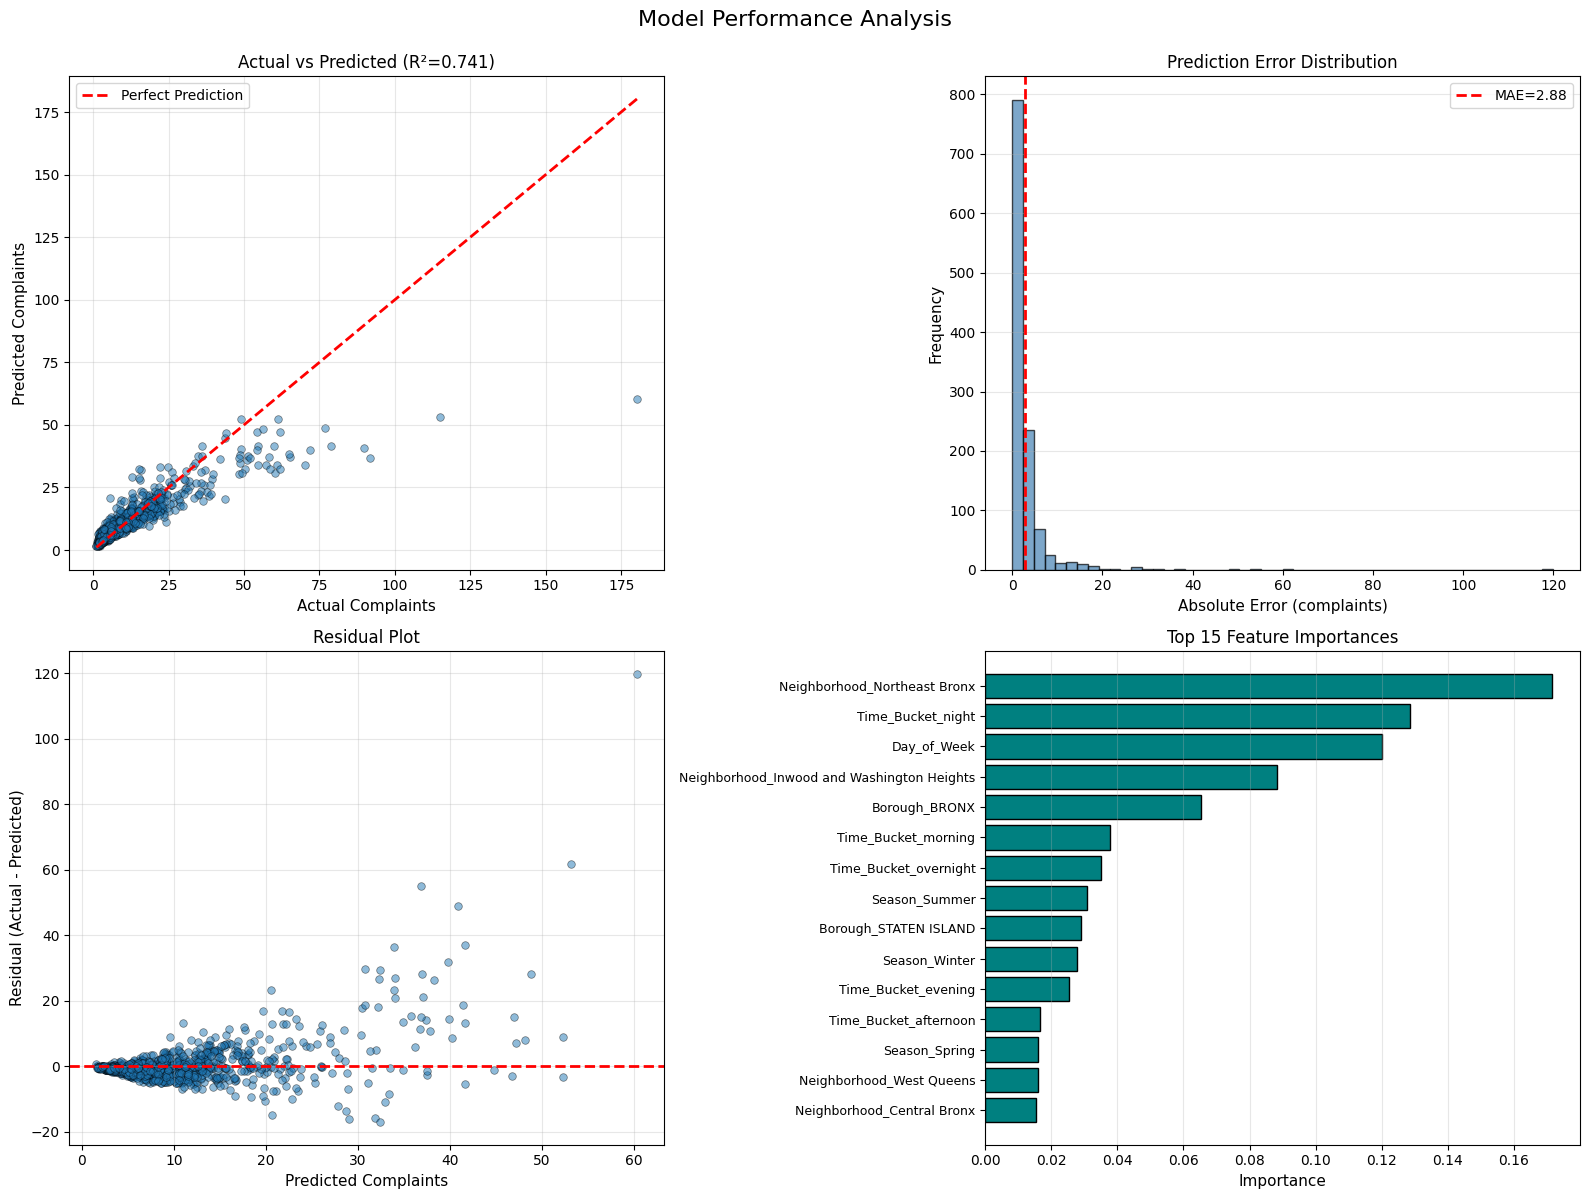

In [18]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Model Performance Analysis', fontsize=16, y=0.995)

# Plot 1: Actual vs Predicted
axes[0, 0].scatter(y_test, y_pred_test, alpha=0.5, s=30, edgecolors='k', linewidth=0.5)
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
                'r--', lw=2, label='Perfect Prediction')
axes[0, 0].set_xlabel('Actual Complaints', fontsize=11)
axes[0, 0].set_ylabel('Predicted Complaints', fontsize=11)
axes[0, 0].set_title(f'Actual vs Predicted (R²={r2_test:.3f})', fontsize=12)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Prediction error distribution
axes[0, 1].hist(errors, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 1].axvline(mae_test, color='red', linestyle='--', linewidth=2, 
                   label=f'MAE={mae_test:.2f}')
axes[0, 1].set_xlabel('Absolute Error (complaints)', fontsize=11)
axes[0, 1].set_ylabel('Frequency', fontsize=11)
axes[0, 1].set_title('Prediction Error Distribution', fontsize=12)
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Plot 3: Residual plot
residuals = y_test - y_pred_test
axes[1, 0].scatter(y_pred_test, residuals, alpha=0.5, s=30, edgecolors='k', linewidth=0.5)
axes[1, 0].axhline(0, color='red', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Predicted Complaints', fontsize=11)
axes[1, 0].set_ylabel('Residual (Actual - Predicted)', fontsize=11)
axes[1, 0].set_title('Residual Plot', fontsize=12)
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Top 15 feature importances
top_features = feature_importance.head(15)
axes[1, 1].barh(range(len(top_features)), top_features['importance'].values, 
                color='teal', edgecolor='black')
axes[1, 1].set_yticks(range(len(top_features)))
axes[1, 1].set_yticklabels(top_features['feature'].values, fontsize=9)
axes[1, 1].set_xlabel('Importance', fontsize=11)
axes[1, 1].set_title('Top 15 Feature Importances', fontsize=12)
axes[1, 1].invert_yaxis()
axes[1, 1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('../outputs/05_model_performance.png', dpi=300, bbox_inches='tight')
print("✓ Saved: ../outputs/05_model_performance.png")

## Saving Model Artifacts

The trained model, feature columns, and evaluation outputs are saved for reproducibility and downstream inference.

In [19]:
# Model
with open('../models/complaint_volume_model.pkl', 'wb') as f:
    pickle.dump(model, f)

# Feature columns
with open('../models/feature_columns.pkl', 'wb') as f:
    pickle.dump(X.columns.tolist(), f)

# Feature importance
feature_importance.to_csv('../outputs/feature_importance.csv', index=False)

metadata = {
    "Model": "RandomForestRegressor",
    "Train Samples": len(X_train),
    "Test Samples": len(X_test),
    "Features": X.shape[1],
    "R² (Test)": r2_test,
    "MAE (Test)": mae_test,
    "RMSE (Test)": rmse_test,
}

pd.DataFrame(metadata, index=["Value"]).T.to_csv(
    "../outputs/model_metadata.csv"
)



## Example Predictions


In [20]:
pd.DataFrame({
    "Actual": y_test.values[:10].round(1),
    "Predicted": y_pred_test[:10].round(1),
    "Error": np.abs(y_test.values[:10] - y_pred_test[:10]).round(1)
})


,Actual,Predicted,Error
0,2.1,2.2,0.1
1,5.3,5.6,0.3
2,5.8,7.7,1.9
3,34.8,37.6,2.8
4,1.5,2.7,1.2
5,1.5,2.0,0.5
6,3.6,8.2,4.5
7,10.9,9.6,1.3
8,2.3,3.1,0.8
9,10.5,14.6,4.2
